# Project 4: Unsupervised Learning
# Data Set: CIFAR-10 - Object Recognition in Images
_Identify the subject of 60,000 labeled images_

**Project Description**: _"[CIFAR-10](https://www.kaggle.com/c/cifar-10/)  is an established computer-vision dataset used for object recognition. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6000 images per class. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton."_

For this project, 2500 random images were selected.

## 1. Introduction

In [55]:
import numpy as np
import pandas as pd
import cv2
import os, os.path
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
#from keras.datasets import cifar10
#from google.colab.patches import cv2_imshow
%matplotlib inline

***
***
**Sandbox Cells:**<br>

In [2]:
os.listdir("train/")[0:5]

['1.png', '10.png', '100.png', '1000.png', '10000.png']

In [3]:
os.path.splitext(os.listdir("train")[1])

('10', '.png')

***
---

In [4]:
# labels of the 50,000 train images
df_labels = pd.read_csv("trainLabels.csv", index_col="id")
df_labels.tail()

,label
id,
49996,bird
49997,frog
49998,truck
49999,automobile
50000,automobile


In [5]:
%%time

# Here we create indices for 2500 random images
np.random.seed(42)
indices = np.random.choice(50000,2500)

# To make things faster, numpy arrays were formed
# They will be concatenated later on a DataFrame
image_array = np.empty(shape=(2500,2500), dtype="uint8")
label_array = np.empty(shape=(2500,1), dtype="object")
name_array = np.empty(shape=(2500,1), dtype="object")

# Now let's get the images and put them into numpy array we crated
for num, indx in enumerate(indices):
    path = f"train/{indx}.png"
    img_array = cv2.imread(path, 0)
    img_array = cv2.resize(img_array, (50,50))
    image_array[num] = img_array.reshape(-1)
    label_array[num] = df_labels.loc[indx, "label"]
    name_array[num] = str(indx) + ".png"

# summon a DataFrame to work on them easier
train_df = pd.DataFrame(np.concatenate([image_array, label_array, name_array], axis=1))
# change the last columns names
train_df = train_df.rename(columns={2501:"Img Name", 2500:"Label"})
# change the data type from 'object' to 'uint8' for the rest
#train_df.iloc[:, :-2] = train_df.iloc[:, :-2].astype("uint8")

Wall time: 1.38 s


In [6]:
train_df.tail(3)

,0,1,2,3,4,5,6,7,8,9,...,2492,2493,2494,2495,2496,2497,2498,2499,Label,Img Name
2497,226,225,224,224,225,225,225,225,225,225,...,222,222,222,222,222,221,223,224,truck,10699.png
2498,170,171,172,174,173,169,170,170,172,170,...,173,170,164,174,180,182,173,166,airplane,9715.png
2499,100,100,101,100,101,102,103,104,103,102,...,102,99,95,95,94,91,94,96,deer,19169.png


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Columns: 2502 entries, 0 to Img Name
dtypes: object(2502)
memory usage: 23.9+ MB


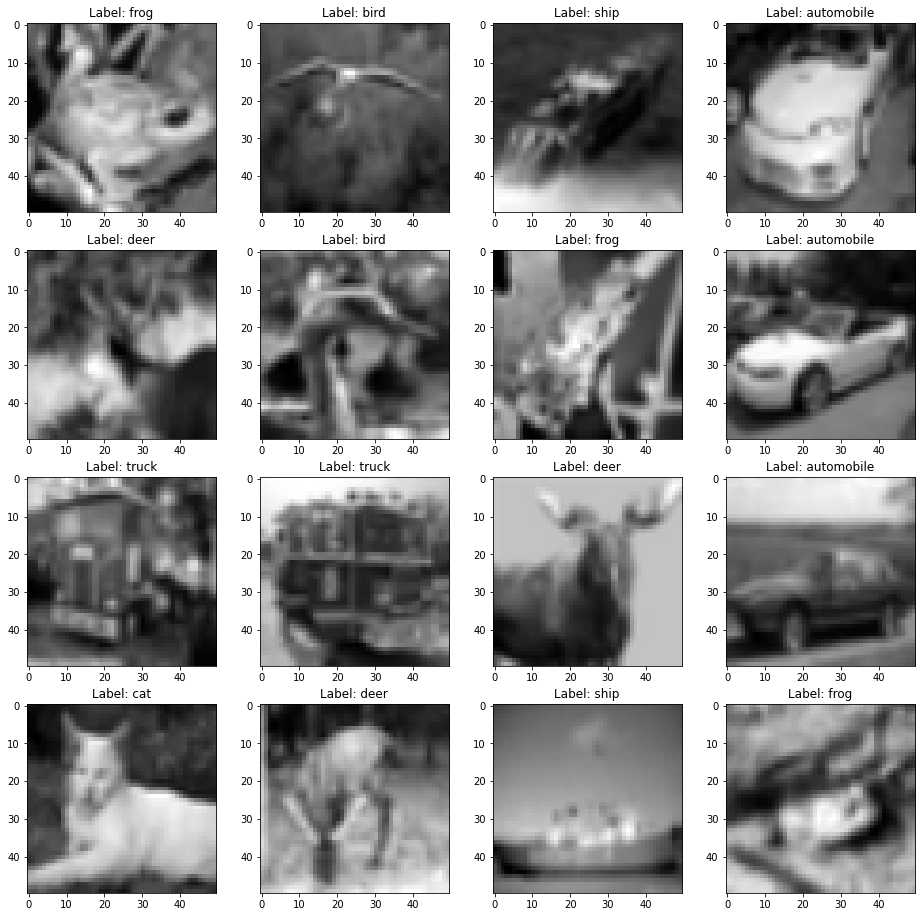

In [29]:
# some of the random choice images
plt.figure(figsize=(16,16))
subplot_num = 1
for i in np.random.randint(0,2500,16):
    plt.subplot(4,4,subplot_num)
    example = np.resize(train_df.iloc[i, :], (50,50)).astype("uint8")
    plt.imshow(example, cmap="gray")
    label = df_labels.loc[indices[i], "label"]
    plt.title(f"Label: {label}", size=12)
    subplot_num+=1
plt.show()
del subplot_num

## 2. Dimensionality Reduction Study

In [9]:
# defining independent variables, X
X = train_df.iloc[:, :-2]

### 2.1 Principle Component Analysis (PCA)

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [11]:
# standardize the values
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

C:\Users\gulme\AppData\Roaming\Python\Python38\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


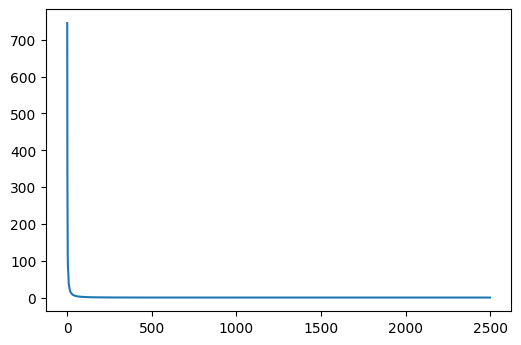

In [13]:
# regarding the eigenvalues, we'll see the variation distribution
X_std_T = X_std.T
C_X = np.cov(X_std_T)
eig_val_cov, eig_vec_cov = np.linalg.eig(C_X)

plt.figure(dpi=100)
plt.plot(eig_val_cov)
plt.show()

In [54]:
# let's take 100 components on our PCA model
pca_model = PCA(n_components=100)
X_pca = pca_model.fit_transform(X_std)

print(f"With {pca_model.n_components_} components, our model explains \
{sum(pca_model.explained_variance_ratio_)*100:.1f}% of our data.")

With 100 components, our model explains 94.9% of our data.


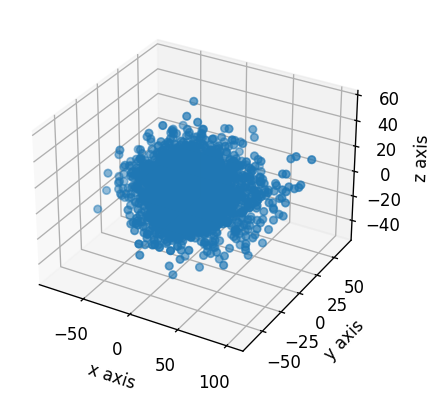

In [61]:
fig=plt.figure(dpi=120)
ax=fig.add_subplot(111, projection="3d")

ax.scatter(X_pca.T[0], X_pca.T[1], X_pca.T[2])
ax.set_xlabel("x axis")
ax.set_ylabel("y axis")
ax.set_zlabel("z axis")

plt.show()

### 2.2 t-distributed Stochastic Neighbor Embedding (t-SNE)